In [1]:
import sys
sys.path.append ('../input/timm-pytorch-image-models/pytorch-image-models-master')
import os
import gc
import time
import math
import random
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from   torch.nn import init
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import get_cosine_schedule_with_warmup, AdamW
from   torch.cuda.amp import autocast, GradScaler
from   torch.optim.lr_scheduler import OneCycleLR
from   torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import _LRScheduler
from   fastai.losses import LabelSmoothingCrossEntropy

# from warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.preprocessing import LabelEncoder
from   sklearn.model_selection import StratifiedKFold, GroupKFold
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score
from   sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

import timm
import albumentations as A
from   albumentations import *
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
# from GPUtil import showUtilization as gpu_usage
# from   numba import cuda
import warnings
warnings.filterwarnings ("ignore")

In [2]:
class CFG:
    device       = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
    num_workers  = 8
    model_name   = 'efficientnet_b3'       # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 512                     # [64, 128, 224, 384, 512, 640, 720]
    isTrain      = True
    isFreeze     = False
    # lr         = 1e-5
    # lrs        = [1e-4, 5e-4, 1e-3]      # if finding optimal lr, CFG.lr will be overriden
    epochs       = 15
    eval_steps   = 0.5                     # if float: these many epochs are with frozen model at the beginning, if int = actual steps 
    warmup_steps = 0.50                    # if float: these many epochs are with frozen model at the beginning, if int = actual steps
    lr_num_cycles= 0.5
    epochsNx     = 1
    criterion    = 'CrossEntropyLoss'  
    grad_accum_steps = 1
    n_classes    = 11014
    use_fc       = False
    fc_dim       = 512
    dropout      = 0.0
    loss_module  = 'arcface'
    s            = 30.0
    margin       = 0.5
    ls_eps       = 0
    theta_zero   = 0.785
    pretrained   = True
    
    weight_decay = 1e-6
    max_grad_norm= 1000.0
    seed         = 42
    n_fold       = 5                        # not used since already loading a 5-folded csv
    train_fold   = [0]                      # [0, 1, 2, 3, 4]
    print_every  = 100
    adam_epsilon = 1e-8
    train_batch_size = 16
    eval_batch_size  = 16
    img_ext          = '.jpg'
    img_col          = "image"
    label_col        = 'label_group'
    model_infer_path_prefix = "."
    model_train_path_prefix = "."
    train_path       = '../input/shopee-product-matching/train_images'
    train_csv        = '../input/shopee-product-matching/train.csv'
    train_folds_csv  = '../input/shopee-folds/folds.csv'
    test_path        = '../input/shopee-product-matching/test_images'
    output_dir       = './results'        # output directory        
    max_steps        = 0
    MODEL            = None
    
# custom scheduler
scheduler_params = {
        "lr_start": 1e-5,
        "lr_max": 1e-5 * CFG.train_batch_size,
        "lr_min": 1e-6,
        "lr_ramp_ep": 5,
        "lr_sus_ep": 0,
        "lr_decay": 0.8,
    }

In [3]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [4]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

seed_everything (CFG.seed)

# Augmentation Dataset

In [5]:
# Dual Cutout implementations
class CutoutV2 (A.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return A.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

In [6]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_transforms (data='train'):
    
    light_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        A.HorizontalFlip (p=0.5),
        A.HueSaturationValue (hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast (brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
        # A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
        # A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        A.CoarseDropout(p=0.5),
        # A.Cutout (max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=2, p=0.75),
        A.Normalize (),
        ToTensorV2 (p=1.0),
    ])
    
    valid_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        A.Normalize (),
        ToTensorV2 (p=1.0),
    ])
    
        
    if 'train' in data:
        return light_transforms
    elif 'valid' in data:
        return valid_transforms
    return valid_transforms

In [7]:
class ImgDataset (Dataset):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_col=CFG.label_col, 
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super ().__init__()
        self.df               = df.reset_index (drop=True)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_col        = label_col
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        file_name = self.df[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'
        image     = cv2.imread (file_path)                         #;print (image.shape)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        image     = self.transform (image=image)['image']
        image     = torch.tensor (image).float ()
        if self.label_col is not None and len (self.label_col) > 0:
            label = torch.tensor (self.df[self.label_col][idx]).long ()
            return image, label
        return image

In [8]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_folds_csv)
    """
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
    """
    labelEncoder = LabelEncoder ()
    train_folds_df[CFG.label_col] = labelEncoder.fit_transform (train_folds_df[CFG.label_col])
    # not required to save the labelEncoder
    CFG.labelEncoder = labelEncoder
    return train_folds_df

35

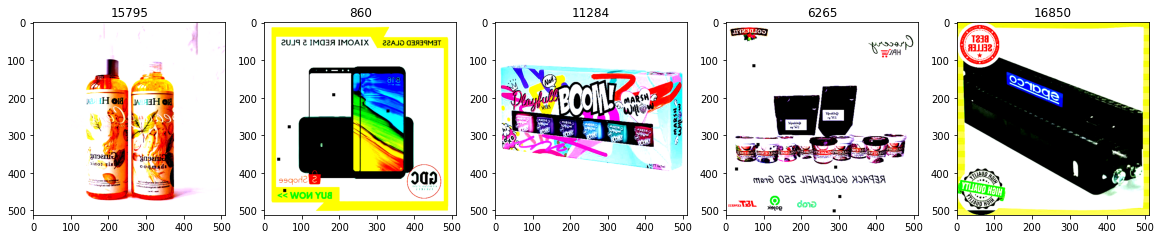

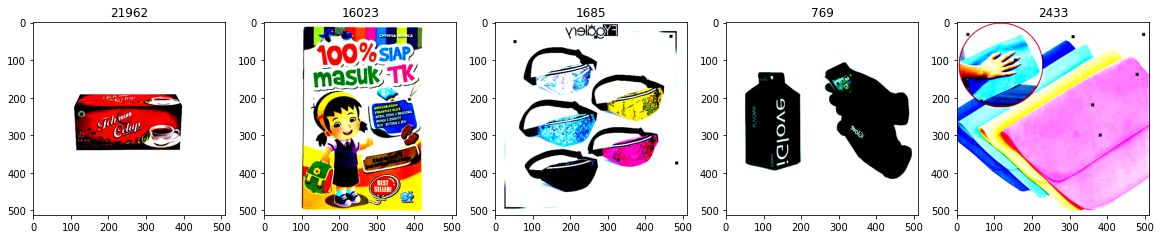

In [9]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                         # ;print (img.size()) ;print (label)
            # img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds (), transform=get_transforms())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [10]:
def get_criterion ():
    
    criterion = None
    if CFG.criterion=='CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss () # LabelSmoothingCrossEntropy ()    
    return criterion

# ArcCos, AdaCos, ArcFace

In [11]:
class AdaCos(nn.Module):
    def __init__(self, in_features, out_features, m=0.50, ls_eps=0, theta_zero=math.pi/4):
        super(AdaCos, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.theta_zero = theta_zero
        self.s = math.log(out_features - 1) / math.cos(theta_zero)
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.weight)
        # dot product
        logits = F.linear(x, W)
        # add margin
        theta = torch.acos (torch.clamp (logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos (theta + self.m)
        one_hot = torch.zeros_like (logits)
        one_hot.scatter_(1, label.view (-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        with torch.no_grad ():
            B_avg = torch.where (one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum (B_avg) / input.size(0)
            theta_med = torch.median (theta)
            self.s = torch.log (torch.clamp (B_avg, min=1e-9)) / (torch.cos(torch.min(self.theta_zero * torch.ones_like(theta_med), theta_med)) + 1e-9)
        output *= self.s
        return output
    
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) --------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt (torch.clamp (1.0 - torch.pow (cosine, 2), 1e-9, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros (cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output
    
class AddMarginProduct(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta) - m
    """

    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super(AddMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device='cuda')
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

# Model

In [12]:
class ShopeeNet(nn.Module):

    def __init__(self,
                 n_classes=CFG.n_classes,
                 model_name=CFG.model_name,
                 use_fc=CFG.use_fc,
                 fc_dim=CFG.fc_dim,
                 dropout=CFG.dropout,
                 loss_module=CFG.loss_module,
                 s=CFG.s,
                 margin=CFG.margin,
                 ls_eps=CFG.ls_eps,
                 theta_zero=CFG.theta_zero,
                 pretrained=CFG.pretrained):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large        
        :param loss_module: One of ('arcface', 'cosface', 'adacos', softmax')
        """
        super(ShopeeNet, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))
        
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
            
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ArcMarginProduct(final_in_features, n_classes,
                                          s=s, m=margin, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x, label):
        feature = self.extract_feat(x)
        if self.loss_module in ('arcface', 'cosface', 'adacos'):
            logits = self.final(feature, label)
        else:
            logits = self.final(feature)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x
    
    def freeze (self):
        
        for param in self.parameters ():
            param.requires_grad = False        
        for param in self.backbone.parameters ():
            param.requires_grad = False
        
        for param in self.final.parameters ():
            param.requires_grad = True
        if self.use_fc:
            for param in self.fc.parameters ():
                param.requires_grad = True
            for param in self.bn.parameters ():
                param.requires_grad = True
        return
    
    def unfreeze (self):
        
        for param in self.backbone.parameters ():
            param.requires_grad = True
        for param in self.parameters ():
            param.requires_grad = True
            
        for param in self.final.parameters ():
            param.requires_grad = True
        if self.use_fc:
            for param in self.fc.parameters ():
                param.requires_grad = True
            for param in self.bn.parameters ():
                param.requires_grad = True
        return

# Custom LR Scheduler

In [13]:
class ShopeeScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ShopeeScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [14]:
def load_state (model_path, model):
        
    # single GPU model_file
    state_dict = torch.load (model_path, map_location=torch.device ('cpu')) # ['state_dict']
    # print (state_dict)
    # state_dict = fix_state_dict (state_dict)
    model.load_state_dict (state_dict)
    return state_dict

In [15]:
def getModel (fold, isTrain=True):
    
    model = ShopeeNet ()
    if isTrain:
        
        # TODO: _infer_ to _train_,   _end to _maxacc
        # model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_start.pth'
        # print ("loading", model_path)
        # load_state (model_path, model)
        pass
    else:
        
        # model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        # load_state (model_path, model)
        pass
    
    # torch.save (model.state_dict (), model_path)
    if CFG.isFreeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

## Trainer Helpers

In [16]:
def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

In [17]:
def sigmoid (x):  
    return np.exp (-np.logaddexp (0, -x))

def compute_metrics (labels, pred_pr, threshold=None):
    
    preds   = pred_pr.argmax (-1)
    if threshold is not None:
        # binary classification
        # preds = pred_pr[:,1] >= threshold
        # multi clf
        preds = pred_pr >= threshold
        
    print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, '#P+ve=', np.sum (preds), '#A+ve=', np.sum (labels))   #TODO: comment this
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='micro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    auc     = -1
    try:
        auc = roc_auc_score (labels, pred_pr)
    except:
        pass
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        'auc'      : auc
    }
    return metrics

# Trainer

In [18]:
class MyTrainer:
    
    def __init__(self, fold, model, train_dataset, eval_dataset, criterion, 
                 compute_metrics=compute_metrics, checkpoint_path=None, isResume=False):
        
        self.fold             = fold
        self.start_epoch      = 0
        self.model            = model
        self.train_dataset    = train_dataset
        self.eval_dataset     = eval_dataset
        self.criterion        = criterion
        self.compute_metrics  = compute_metrics
        self.isTrained        = False
        self.device           = CFG.device
        self.optimizer        = torch.optim.Adam (model.parameters (), lr=scheduler_params['lr_start'])
        self.epochs           = CFG.epochs
        self.grad_accum_steps = CFG.grad_accum_steps
        self.set_dataLoaders ()
        self.training_stats   = []
        self.modelFile        = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}.pth"
        if eval_dataset is not None:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.isFreeze}_{CFG.size}_fold{self.fold}_min_val_loss.pth"
            self.maxAucModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.isFreeze}_{CFG.size}_fold{self.fold}_max_val_auc.pth"
        else:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.isFreeze}_{CFG.size}_fold{self.fold}_min_tr_loss.pth"
            self.maxAucModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.isFreeze}_{CFG.size}_fold{self.fold}_max_tr_auc.pth"
        
        self.min_val_loss         = 9999
        self.min_train_loss       = 9999
        self.max_val_auc          = -1
        
        # load checkpoint
        if checkpoint_path is not None:
            if isResume:
                self.start_epoch = self.load_checkpoint (checkpoint_path, isResume=True) + 1
            else:
                self.load_checkpoint (checkpoint_path, isResume=False)
        self.model = self.model.to (CFG.device)
        if CFG.isFreeze:
            self.model.freeze ()
        else:
            self.model.unfreeze ()
        CFG.MODEL = self.model
        return
    
    def set_dataLoaders (self):
        # Create the DataLoaders for our training and validation sets.
        
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = RandomSampler (self.train_dataset)           # Better use RandomSampler
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = CFG.train_batch_size,
                    num_workers = CFG.num_workers,
                    pin_memory  = True
        )
        # train_dataloader  = DataLoader (self.train_dataset, batch_size=CFG.train_batch_size) # TODO: comment this
        validation_dataloader = None
        if self.eval_dataset:
            validation_dataloader = DataLoader (
                        self.eval_dataset, 
                        sampler     = SequentialSampler (self.eval_dataset),
                        batch_size  = CFG.eval_batch_size,
                        num_workers = CFG.num_workers,
                        pin_memory  = False
            )
            # validation_dataloader  = DataLoader (self.eval_dataset, batch_size=CFG.eval_batch_size) # TODO: comment this
        
        if type (CFG.warmup_steps) is float:
            CFG.warmup_steps = int (CFG.warmup_steps * len (train_dataloader))
        # Total number of training steps is [number of batches] x [number of epochs]
        num_training_steps = (len (train_dataloader) * self.epochs) // self.grad_accum_steps + 1
        # lr_scheduler = get_cosine_schedule_with_warmup (self.optimizer, num_cycles=CFG.lr_num_cycles,
        #                 num_warmup_steps=CFG.warmup_steps, num_training_steps=num_training_steps)
        # lr_scheduler = OneCycleLR (self.optimizer, max_lr=CFG.lr, total_steps=num_training_steps)
        lr_scheduler   = ShopeeScheduler (self.optimizer,**scheduler_params)
        
        if type (CFG.eval_steps) is float:
            CFG.eval_steps = int (CFG.eval_steps * len (train_dataloader))
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps = train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
        return
            
    def test_iterate_dataloader (self):
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    def save_checkpoint (self, epoch, path):
        
        checkpoint = {
            'epoch'               : epoch,
            'model_state_dict'    : self.model.state_dict (),
            'optimizer_state_dict': self.optimizer.state_dict (),
            'lr_sched_state_dict' : self.lr_scheduler.state_dict (),
            'training_stats'      : self.training_stats,
            'max_val_auc'         : self.max_val_auc,
            'min_train_loss'      : self.min_train_loss,
            'min_val_loss'        : self.min_val_loss,
        }
        torch.save (checkpoint, path)
        gc.collect (); torch.cuda.empty_cache ()
        print ("saved checkpoint", path)
        return
    
    def load_checkpoint (self, path, isResume=False):
        
        epoch      = 0
        checkpoint = torch.load (path, map_location=torch.device ('cpu'))
        self.model.load_state_dict (checkpoint['model_state_dict'])
        if isResume:
            
            self.optimizer.load_state_dict (checkpoint['optimizer_state_dict'])
            self.lr_scheduler.load_state_dict (checkpoint['lr_sched_state_dict'])
            epoch = checkpoint['epoch']
            self.training_stats  = checkpoint['training_stats']
            self.min_val_loss    = checkpoint['min_val_loss']
            self.min_train_loss  = checkpoint['min_train_loss']
            self.max_val_auc     = checkpoint['max_val_auc']
            print ("Loaded model, optimizer, and lr_scheduler from -", path)
            print ('Last min_val_loss =', self.min_val_loss)
            print ('Last teain stats =', self.training_stats[-1])
        else:
            print ("Loaded model from -", path)
            
        self.model.train ()
        return epoch
    
    def train (self):
        
        seed_everything (seed=CFG.seed)
        step             = 0
        total_t0         = time.time ()
        scaler           = GradScaler()
        # self.model.to (self.device) #   already done in init ()
        torch.autograd.set_detect_anomaly (True) 
        for epoch_i in range (self.start_epoch, self.epochs):
            
            avg_epoch_train_loss   = 0
            total_epoch_train_loss = 0
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            t0 = time.time ()
            self.model.train ()
            tqdm_tr = tqdm (enumerate (self.train_dataloader), total=len(self.train_dataloader))
            for stp, batch in tqdm_tr:
                
                # Print Stats
                # if step % CFG.print_every == 0:
                #     elapsed = format_time (time.time() - t0)
                #     print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format (step, len (self.train_dataloader), elapsed))                
                if ((CFG.max_steps > 0 and CFG.max_steps < step) or 
                    (CFG.eval_steps>0 and stp==CFG.eval_steps)): # or step==0): 
                    
                    self.save_checkpoint (epoch_i, self.modelFile)
                    training_time = format_time (time.time () - t0)            
                    if self.validation_dataloader:
                        with torch.no_grad ():
                            
                            avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                            # save this model if the eval loss decreases from the minimum so far
                            checkpoint_epoch = epoch_i
                            if stp==CFG.eval_steps:
                                # don't count this epoch in the checkpoint since this epoch 
                                # has not completed. Hence, checkpoint at prev epoch
                                checkpoint_epoch = epoch_i-1
                            if avg_val_loss < self.min_val_loss:                             
                                self.min_val_loss = avg_val_loss
                                self.save_checkpoint (checkpoint_epoch, self.minLossModelFile)
                            if avg_val_auc > self.max_val_auc:
                                self.max_val_auc = avg_val_auc
                                self.save_checkpoint (checkpoint_epoch, self.maxAucModelFile)
                    if CFG.max_steps > 0 and CFG.max_steps < step:
                        
                        print ("")
                        print ("Training complete!")
                        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
                        self.isTrained = True
                        self.model.cpu ()
                        self.model.eval ()
                        self.save_checkpoint (epoch_i, self.modelFile)
                        try:
                            torch.cuda.empty_cache ()
                            self.plot_train_stats (self.training_stats)
                        except:
                            pass
                        return pd.DataFrame (self.training_stats)
                
                ########################################################
                # Train
                ########################################################
                # self.model.zero_grad ()                        
                images = batch[0].to (self.device)
                labels = batch[1].to (self.device)
                # with autocast ():
                    
                logits = self.model (images, labels)
                loss   = self.criterion (logits, labels) / self.grad_accum_steps
                # scaler.scale (loss).backward ()
                loss.backward ()
                if (stp+1) % self.grad_accum_steps == 0:
                    
                    torch.nn.utils.clip_grad_norm_ (self.model.parameters (), CFG.max_grad_norm)
                    # scaler.step (self.optimizer)
                    self.optimizer.step ()
                    # scaler.update ()
                    self.optimizer.zero_grad ()
                    # update the lr after every batch
                    # self.lr_scheduler.step ()
                    
                total_epoch_train_loss += loss.cpu ().item () * self.grad_accum_steps
                avg_epoch_train_loss    = total_epoch_train_loss / (stp+1)
                step += 1
                tqdm_tr.set_postfix (TrainLoss=avg_epoch_train_loss, Epoch=epoch_i+1, LR=self.optimizer.param_groups[0]['lr'])
            
            # update the lr at epoch end
            if self.lr_scheduler is not None:
                self.lr_scheduler.step ()
            # all steps of an epoch end here
            
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.4f}".format (avg_epoch_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))            
            if self.validation_dataloader:    
                with torch.no_grad ():
                    avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                    # save this epoch's model if the eval loss decreases from the minimum so far
                    if avg_val_loss < self.min_val_loss:                    
                        self.min_val_loss = avg_val_loss
                        self.save_checkpoint (epoch_i, self.minLossModelFile)
                    if avg_val_auc > self.max_val_auc:
                        self.max_val_auc = avg_val_auc
                        self.save_checkpoint (epoch_i, self.maxAucModelFile)
            else:             
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_epoch_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < self.min_train_loss:                     
                    self.min_train_loss = avg_train_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
            self.save_checkpoint (epoch_i, self.modelFile)
            # 1 epoch end
        # all epochs end
        
        print ("***** Training complete! *****")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.model.cpu ()
        self.model.eval ()
        try:
            torch.cuda.empty_cache ()
            self.plot_train_stats (self.training_stats)
        except:
            pass
        CFG.MODEL = self.model
        return pd.DataFrame (self.training_stats)
    
    
    def evaluate (self, epoch_i, avg_train_loss=999, training_time=999):
        
        t0           = time.time ()
        all_labels   = []
        all_pred_prs = []
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()

        # Tracking variables 
        total_eval_mcc       = 0
        total_eval_f1        = 0
        total_eval_precision = 0
        total_eval_recall    = 0
        total_eval_auc       = 0
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                images   = batch[0].to (self.device)
                labels   = batch[1].to (self.device)
                logits   = self.model (images, labels)
                loss     = self.criterion (logits, labels).detach ().cpu ()
                labels   = labels.cpu ().numpy ()
                pred_prs = torch.softmax (logits, -1).detach ().cpu ().numpy ()
                
            total_eval_loss += loss.item ()            
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            all_labels.append (labels)
            all_pred_prs.append (pred_prs)
        # all iterations in an epoch end
        
        all_labels   = np.concatenate (all_labels)
        all_pred_prs = np.vstack (all_pred_prs)
        metrics      = self.compute_metrics (all_labels, all_pred_prs)
        # Report the final accuracy for this validation run.
        avg_val_f1   = metrics['f1']
        print ("  F1: {0:.4f}".format (avg_val_f1))
        avg_val_mcc  = metrics['mcc']
        print ("  MCC: {0:.4f}".format (avg_val_mcc))
        avg_val_precision = metrics['precision']
        print ("  Precision: {0:.4f}".format (avg_val_precision))
        avg_val_recall = metrics['recall']
        print ("  Recall: {0:.4f}".format (avg_val_recall))
        avg_val_auc = metrics['auc']
        print ("  AUC: {0:.4f}".format (avg_val_auc))
        avg_val_accuracy = metrics['accuracy']
        print ("  Accuracy: {0:.4f}".format (avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len (self.validation_dataloader)
        print ("  Validation Loss: {0:.4f}".format (avg_val_loss))
        # Measure how long the validation run took.
        validation_time = format_time (time.time () - t0)
        
        self.training_stats.append ({
                'epoch'         : epoch_i + 1,
                'training_loss' : avg_train_loss,
                'eval_loss'     : avg_val_loss,
                'eval_f1'       : avg_val_f1,
                'eval_mcc'      : avg_val_mcc, 
                'eval_precision': avg_val_precision,
                'eval_recall'   : avg_val_recall,
                'eval_auc'      : avg_val_auc, 
                'eval_accuracy' : avg_val_accuracy,
                'training_time' : training_time,
                'eval_time'     : validation_time                   
        })
        self.model.train ()
        print ("Validation took {:} (h:mm:ss)".format (format_time (time.time () - t0)))
        return avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time
    
    """
    def find_and_set_lr (self, lrs=CFG.lrs, iterations=2):
        # after iterations compare the last iterations loss for each loss and select the min loss lr
        # consider only 'batch_count' batches for calculating the losses
        
        
        path = "./init.pt"
        self.save_checkpoint (0, path)
        batch_count = CFG.grad_accum_steps    # 100 // CFG.train_batch_size + 1
        lr_loss = []        
        for lr in tqdm (lrs, total=len (lrs)):  
            self.load_checkpoint (path)
            self.model.train ()
            self.optimizer = AdamW (self.model.parameters (), lr=lr, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)
            for epoch_i in range (iterations):
                total_epoch_train_loss = 0
                avg_epoch_train_loss   = 0
                for stp, batch in enumerate (self.train_dataloader):
                    
                    images = batch[0].to (self.device)
                    labels = batch[1].to (self.device)
                    # with autocast ():
                    logits = self.model (images, labels)
                    loss   = self.criterion (logits, labels) / self.grad_accum_steps
                    # scaler.scale (loss).backward ()
                    loss.backward ()
                    if (stp+1) % self.grad_accum_steps == 0:

                        torch.nn.utils.clip_grad_norm_ (self.model.parameters (), CFG.max_grad_norm)
                        # scaler.step (self.optimizer)
                        self.optimizer.step ()
                        # scaler.update ()
                        self.optimizer.zero_grad ()

                    total_epoch_train_loss += loss.cpu ().item () * self.grad_accum_steps
                    avg_epoch_train_loss    = total_epoch_train_loss / (stp+1)
                    if (stp+1) % batch_count == 0:
                        break
                if epoch_i == iterations-1:
                    lr_loss.append ((lr, avg_epoch_train_loss))
        
        min_lr   = -1 
        min_loss = 999999
        for lr, avg_epoch_train_loss in lr_loss:
            if avg_epoch_train_loss < min_loss:
                min_lr   = lr
                min_loss = avg_epoch_train_loss
        
        print ("Optimal LR =", min_lr, "at loss =", min_loss)
        CFG.lr = min_lr
        self.optimizer    = AdamW (self.model.parameters (), lr=CFG.lr, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)
        self.lr_scheduler = OneCycleLR (self.optimizer, max_lr=CFG.lr, total_steps=self.num_training_steps)
        self.load_checkpoint (path)
        self.model.train ()
        return min_lr        
    """
        
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        mccs   = accuracies = f1_scores = precisions = recalls = auc = losses = epochs = -1
        epochs = len (training_stats)
        if 'eval_mcc' in training_stats[0]:
            mccs       = [e['eval_mcc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_mcc')
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_f1' in training_stats[0]:
            f1_scores  = [e['eval_f1'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=f1_scores,  label='val_f1') 
        if 'eval_precision' in training_stats[0]:
            precisions = [e['eval_precision'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=precisions, label='val_precision')
        if 'eval_recall' in training_stats[0]:
            recalls    = [e['eval_recall'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=recalls,    label='val_recall')
        if 'eval_auc' in training_stats[0]:
            auc        = [e['eval_auc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_auc')
        if 'eval_loss' in training_stats[0]:
            losses     = [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('mccs       :', mccs)
        print ('accuracies :', accuracies)
        print ('precisions :', precisions)
        print ('recalls    :', recalls)
        print ('f1_scores  :', f1_scores)
        print ('auc        :', auc)
        print ('losses     :', losses)
        print ('tr_losses  :', tr_losses)
        
        plt.plot (recalls, precisions, marker='.', label='Prcision-Recall Curve')
        # axis labels
        plt.xlabel ('Recall')
        plt.ylabel ('Precision')
        # show the legend
        plt.legend ()
        # show the plot
        plt.show ()
        return
    
    
    def get_model (self):
        
        if self.isTrained:
            return self.model.eval ()
        return None

In [19]:
def free_gpu_cache ():
    
    # print("Initial GPU Usage")
    # gpu_usage()                             

    torch.cuda.empty_cache()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    # print("GPU Usage after emptying the cache")
    # gpu_usage()
    return

# free_gpu_cache()           

## Train

In [20]:
def train_fold_loop (fold, train_df, checkpoint_path=None, isResume=False):

    print (f"========== fold: {fold} training ==========")

    trn_idx        = train_df[train_df['fold'] != fold].index
    val_idx        = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True) 
    # class_wt       = 1 / (1 + np.array (train_df[CFG.label_cols].sum (axis=0).values))
    # class_wt       = torch.tensor (class_wt / np.sum (class_wt)).to (CFG.device)   ;print ('class_wt =', class_wt)
    # class_wt       = class_wt.to (CFG.device)    
    criterion      = get_criterion ()
    model          = CFG.MODEL
    if model is None and checkpoint_path is None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=True)
        model      = model.float ()
    elif model is not None and checkpoint_path is not None:
        # ignore checkpoint
        checkpoint_path = None
    elif model is None and checkpoint_path is not None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=False)
        model      = model.float ()
        
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))    
    trainer        = MyTrainer (
        fold            = fold,
        model           = model,
        train_dataset   = train_dataset,
        eval_dataset    = valid_dataset,
        criterion       = criterion,
        compute_metrics = compute_metrics,
        checkpoint_path = checkpoint_path,
        isResume        = isResume
    )
    # trainer.find_and_set_lr ()
    metrics = trainer.train ()
    return metrics
    
    # To plot lr uncomment this
    # lrs = [scheduler_params["lr_start"]]
    # for i in range (CFG.epochs*3): # *len (trainer.train_dataloader)):
    #     trainer.lr_scheduler.step ()
    #     lrs.append (trainer.optimizer.param_groups[0]["lr"])
    # print (lrs)
    # plt.plot (lrs)
    # plt.show ()

In [21]:
def train_main (checkpoint_path=None, isResume=False):
    
    print (f"========== train_main() ==========")
    train_df = getFolds ()
    if CFG.isTrain:        
        valid_scores_df = pd.DataFrame ()
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                
                valid_scores_fold_df = train_fold_loop (fold, train_df, checkpoint_path, isResume)
                # valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores_df = valid_scores_df.append (valid_scores_fold_df)
                
        print (f"========== CV ==========")
        # print (valid_scores_df)
        # valid_scores = np.vstack (valid_scores)
        # valid_scores = np.mean (valid_scores, axis=0)
        valid_scores = valid_scores_df.iloc[-1, :]  #.mean ()
        print ("CV Scores :-");  print (valid_scores)
    return valid_scores_df

# Single config training

!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
model_names = timm.list_models (pretrained=True)
model_names = timm.list_models ('*resnet*', pretrained=True)
pprint (model_names)
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)

valid_scores_df = train_main ()

valid_scores_df

# To train, uncomment these

gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
CFG.eval_steps   = 0.5
CFG.num_workers  = 8
CFG.size = 128         # [128, 224, 384, 512, 640, 1024]
CFG.train_batch_size = 1024 * 1
CFG.eval_batch_size  = 1024 * 1
CFG.freeze = True
CFG.epochs = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
CFG.eval_steps   = 0.5
CFG.num_workers = 8
CFG.size = 128
CFG.train_batch_size = 64
CFG.eval_batch_size  = 64
CFG.isFreeze = False
CFG.epochs = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 224
CFG.train_batch_size = 348
CFG.eval_batch_size  = 348
CFG.isFreeze         = True
CFG.epochs           = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_224_fold0.pth")
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 224
CFG.train_batch_size = 34
CFG.eval_batch_size  = 34
CFG.isFreeze         = False
CFG.epochs           = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 384
CFG.train_batch_size = 104
CFG.eval_batch_size  = 104
CFG.isFreeze         = True
CFG.epochs           = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_384_fold0.pth")
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 384
CFG.train_batch_size = 12
CFG.eval_batch_size  = 12
CFG.isFreeze         = False
CFG.epochs           = 4
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 512
CFG.train_batch_size = 24
CFG.eval_batch_size  = 24
CFG.isFreeze         = True
CFG.grad_accum_steps = 1
CFG.epochs           = 3
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.eval_steps       = 0.5
CFG.size             = 512
CFG.train_batch_size = 16
CFG.eval_batch_size  = 16
CFG.grad_accum_steps = 1
CFG.isFreeze         = False
CFG.epochs           = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

***** Training for size=512 freeze=False *****
========== train_main() ==========
========== fold: 0 training ==========
CFG.MODEL is None
Building Model Backbone for efficientnet_b3 model


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


======== Epoch 1 / 5 ========


  3%|▎         | 53/1713 [01:14<33:18,  1.20s/it, Epoch=1, LR=1e-5, TrainLoss=23.9] 

In [ ]:
# !rm -f ./init.pt
print ('Done !')